# Introdução
Neste segundo estudo vamos incorporar variação aos parâmetros **beta e gama** pois como vimos nos exemplos do estudo anterior 
# O Modelo SIR Comportamental
Um modelo comportamental engloba mais compartimentos além dos três do SIR padrão e adiciona uma variação no índice de propagação &beta; em função de um ou mais compartimentos adicionados. 
Tanto o comportamento indiviudual como as diretrizes de sáude pública em relação ao isolamento social variam por vários fatores mas julgamos dois críticos e predominantes: o número de atendimentos hospitalares e o número de internações em utis. Obviamente o número de mortes seria o fator preponderante mas como ele surge sempre após os dois citados nosso estudo considerará os primeiros como propulsores de conscientização individual ou de fixação de políticas públicas que interfiram no fator &beta; de propagação da epidemia  
## Leis de movimento da epidemia
Segundo o [trabalho](https://) de Jesus Fernandez Villaverde e Charles I. Jones
podemos definir um modelo **SIR Comportamental** pelas seguintes leis:  
Seguindo as nomenclaturas da literatura tradiconal teremos o seguinte diagrama de fluxo cronológico da  epidemia:  

${\Large S \xrightarrow{} I \xrightarrow{} R \xrightarrow{} H \xrightarrow{} U \xrightarrow{} D\  or \xrightarrow{} C}$  

Onde:  

$S_t = Suscetíveis$  
$I_t = Infectados$  
$R_t = Em\ resolução$  
$H_t = Hospitalizados$  
$U_t = Em\  UTI$  
$D_t = Mortos$  
$C_t = Recuperados$  
  
  
**Leis:**  

${\displaystyle \Delta S_{t+1} = \frac{-\beta S_tI_t}{N}}$  
  
  
${\displaystyle \Delta I_{t+1} = \frac{\beta S_tI_t}{N} - \gamma I_t}$  
  
$\Delta R_{t+1} = \gamma I_t - \theta R_t$  
  
$\Delta D_{t+1} = \delta \theta R_t$  
  
$\Delta C_{t+1} = (1 - \delta) \theta R_t$


## Variando Beta &beta;

Produziremos a seguir um algorítmo para a incorporação de uma simples variação de &beta e/ou &gamma num cluster e a partir de um determinado tempo, tal situação se dá, por exemplo, na redução de &beta por medidas de isolamento social ou na redução de 1/&gamma no surgimento de novas terapias ou medicamentos.  

## Variando Gama &gamma; e Teta &theta;
O variação de gama se dá de uma forma completamente diferente da variação de &beta; em vez de ter sua variação exponencialemnte alterada em função dos fatores de hospitalização, uso de utis e mortes, como &beta;, &gama; e &theta;  podem variar em função do surgimento de novas terapias e medicamentos.

## Código
### Dados de entrada:
Além dos parâmetros necessários como as condições iniciais para a integração das equações difeneciais vamos utilizar os seguintes: (todos constantes para este estudo primeiro estudo)  
  
**Parâmetros e variáveis epidemiológicas utilizadas no código**  

Parâmetro e Variáveis | Descrição | Observações
--|--|--
**Fatores principais** |
pop | População do cluster | Fixa, desconsiderando o fator vital
i_ini | População infectada inicial |
s_ini | Susctíveis iniciais |
r_ini | Em recuperação iniciais |
r_zero_max | Taxa de propagação máxima | Infectados por um único indivíduo.
r_zero_mim | Taxa de propagação mínima |  Infectados por um único indivíduo.
gama_inv | Período infectante | Em que o indivíduo transmite a infecção
gama | Fator de infeccção | 1 / dias_infec
beta_max | Fator de propagação máximo | beta = r_zero_max * gama
beta_min | Fator de propagação mínimo | beta = r_zero_min * gama
**Fatores anexos** |
fat_confirm | Fator de infectados confirmados | Casos confirmados = fat_confim * Infectados
fat_uti | Fator de internação em UTIS | Intenação UTIs = fat_uti * Casos confirmados
fat_mort | Sobre os casos confirmados | Mortes = Uti * fat_mort
**Fatores temporais**
data_ini | Data inicial da epidemia no cluster | ano-mês-dia
tot_dias | Total de dias da análise | A partir de data_ini  
  
  
A seguir, o código em python para analisarmos várias hipóteses e traçar diretrizes a um trabalho com maior profundidade.  
**Next:**  
* Inserir vetor para beta e gama para variações, por exemplo
  * Cluster_1 

**Next file:**
* Inserir vários clusters


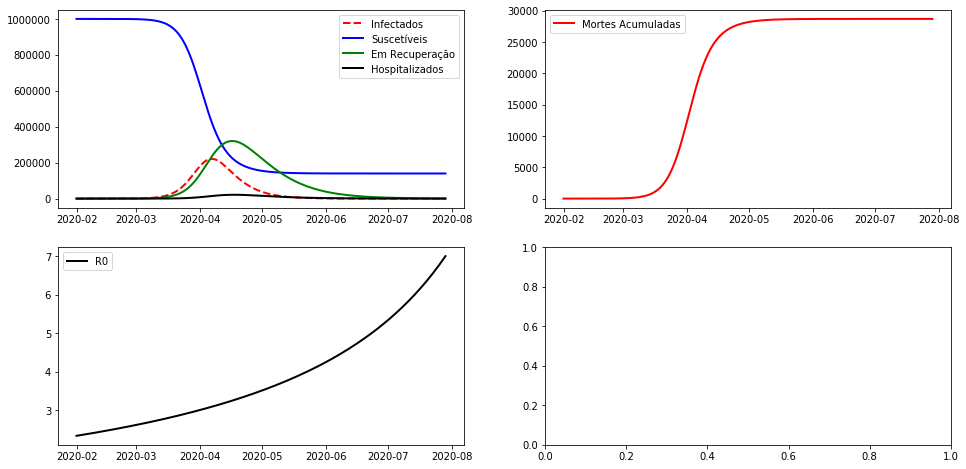

In [32]:
# -*- coding: utf-8 -*-
"""
Created on Tue May  5 17:40:00 2020

@author: 
pedro eduardo souza abreu pedu.abreu@gmail.com
pedro vitor abreu  eng.pva@gmail.com
"""

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

def run(
        s_ini: 'suscetíveis',
        i_ini: 'infectados iniciais',
        r_ini: 'recuperados iniciais',
        r_zero_max: 'razão de reprodução max',
        r_zero_min: 'razão de reprodução min',
        gama_inv: 'período de recuperação',
        t_max: 'tempo total analisado',
        data_ini: 'data inicial') -> pd.DataFrame:
    
    s_ini = pop - i_ini - r_ini    
    gama = 1/gama_inv if gama_inv != 0 else 1
    beta_max = gama * r_zero_max
    beta_min = gama * r_zero_min
    t_list = range(t_max)
    seq_dias = np.arange(data_ini, data_ini + t_max, dtype= 'datetime64[D]')
    res_integr = integrar(s_ini, i_ini, r_ini, beta_max, beta_min, gama, t_max)
    # res_integr = odeint(eq_dif, y_ini, t, args=(pop,beta,gama))
    s,i,r,i_acum, h,u,m,imun,b = res_integr
    r0 = 1/b
    return pd.DataFrame({'S': s, 'I': i, 'R': r, 'I_acum':i_acum,'D': seq_dias, 
                        'H': h, 'U': u, 'M': m, 'Imun': imun, 'R0': r0},
                        index=t_list)

def casos_por_dia(
        ia: 'serie acumulada'):
    i_dia = np.zeros(len(ia))
    i_dia[0] = ia[0]
    for j in range(1,len(ia)):
        i_dia[j] = ia[j] - ia[j-1]
    return i_dia

# todo: 
#    expressar beta como função exponencial de h(t)
#    compatibilizar variáveis de fatores, inclusive no markdown
def integrar(
    si: 'suscetíveis iniciais',
    ii: 'infectados iniciais',
    ri: 'resolvendo inicias',
    b_max: 'taxa de propagação S->I (max)',
    b_min: 'taxa de propagação S->I (min)',
    g: 'taxa de recuperação I->R',
    t_max: 'número de dias analisados'
    ): # retorna (s,i,r,i_acum) np.array
    s = np.zeros(t_max, dtype = float)
    i = s.copy(); r = s.copy(); i_acum = s.copy()
    # hospitalizado, uti, mortos, imunizados
    h = s.copy(); u = s.copy(); m = s.copy(); imun = s.copy()
    b = np.linspace(b_max, b_min, t_max) # linspace só p/ teste
    s[0] = si
    i_acum[0] = ii
    i[0] = ii
    b[0] = b_max
    n = si + ii + ri
    for t in np.arange(t_max - 1, dtype = int):
        s[t+1]      = s[t] - (b[t] * s[t] * i[t] / n)
        i[t+1]      = i[t] + (b[t] * s[t] * i[t] / n) - (g * i[t])
        r[t+1]      = r[t] + g * i[t] - f_hosp * r[t]        
        h[t+1]      = f_hosp * r[t]
        u[t+1]      = f_uti * h[t]
        # se uti > uti_max então f_morte = 1 ao excedente de uti_max
        m[t+1]      = (f_uti * f_morte) * r[t]
        imun[t+1]   = imun[t] + (1- (f_morte * f_uti)) * f_hosp * r[t]
        i_acum[t+1] = i_acum[t] + (b[t] * s[t] * i[t] / n)
    return (s,i,r,i_acum,h,u,m,imun,b)

# todo: refazer a plotagem para subplots
def plotar(
        tit: 'Título da figura de plotagem, incui parâmetros principai',
        res: 'DataFrame com resultados',
        data_plt_ini: 'ano-mes-dia inicio da plotagem',
        data_plt_fim: 'ano-mes-dia fim da plotagem'):
    
    fig = plt.figure(edgecolor='b', facecolor='whitesmoke', figsize=(15,7.5))
    ax1 = fig.add_subplot(111)
    ax2 = fig.add_subplot(221)
    ax2.yaxis.set_label_position('right')
    ax2.yaxis.tick_right()
    ax3 = ax1.twinx()    
    showdate_ini = np.datetime64(data_plt_ini)
    showdate_end = np.datetime64(data_plt_fim)
    
    ax1.plot(res['D'], res['I_acum'] * f_hosp * f_morte, 'r',
             alpha=0.5, lw=2, label="Mortes Acumuladas")
    ax3.plot(res['D'], casos_por_dia(res['I_acum']) * f_hosp * f_morte,'k--',
             alpha=0.5,lw=1, label="Mortes por Dia")
    ax2.plot(res['D'], res['I'] , 'r--', alpha=0.5, lw=2, label="Infectados")
    ax2.plot(res['D'], res['S'], 'b', alpha=0.5, lw=2, label="Suscetíveis")
    ax2.plot(res['D'], res['R'], 'g', alpha=0.5, lw=2, label="Em Recuperação")
    ax2.plot(res['D'], res['H'], 'k', alpha=0.5, lw=2, label="Hospitalizados")
    
    ax1.set_ylabel('Casos Acumulados')
    ax1.set_xlim(showdate_ini,showdate_end)
    ax2.set_ylabel('Casos Acumulados')
    ax2.set_ylim(0,pop)
    ax2.set_xlim(showdate_ini,showdate_end )
    ax3.set_ylabel('Mortes por dia')
    
    ax1.set_xticks(np.arange(showdate_ini,showdate_end , 2, dtype='datetime64[D]'))
    ax1.set_yticks(np.arange(0, pop/1_000 , pop/10_000))
    ax1.xaxis.set_tick_params(rotation=90) 
    ax2.set_xticks(np.arange(showdate_ini,showdate_end , 7, dtype='datetime64[D]'))
    ax2.xaxis.set_tick_params(rotation=90)
    ax1.grid(b=True, which='major', c='silver', lw=1, ls='-')   
    ax2.grid(b=True, which='major', c='silver', lw=0.5, ls='-')    
    ax1.set_title(tit, fontsize=12, pad =15)
        
    legend_1 = ax1.legend(loc= 'upper right')
    legend_1.get_frame().set_alpha(1)
    legend_2 = ax2.legend()
    legend_2.get_frame().set_alpha(1)    
    ax3.legend(loc= 'lower right')

def plote(
        tit: 'Título da figura de plotagem, incui parâmetros principai',
        res: 'DataFrame com resultados',
        data_plt_ini: 'ano-mes-dia inicio da plotagem',
        data_plt_fim: 'ano-mes-dia fim da plotagem'):
    fig, a = plt.subplots(2, 2, figsize=(16,8))
   
    a[0][0].plot(res['D'], res['I'] , 'r--', lw=2, label="Infectados")
    a[0][0].plot(res['D'], res['S'], 'b', lw=2, label="Suscetíveis")
    a[0][0].plot(res['D'], res['R'], 'g', lw=2, label="Em Recuperação")
    a[0][0].plot(res['D'], res['H'], 'k', lw=2, label="Hospitalizados")
    a[0][1].plot(res['D'], res['I_acum'] * f_hosp * f_morte, 'r', lw=2, 
              label="Mortes Acumuladas")
    a[1][0].plot(res['D'], res['R0'], 'k', lw=2, label="R0")
    
    a[0][0].legend(loc= 'upper right')
    a[0][1].legend(loc= 'upper left')
    a[1][0].legend(loc= 'upper left')

if __name__ == '__main__':
    pop = 1_000_000
    i_ini,r_ini = 1, 0
    r_zero_max, r_zero_min, gama_inv = 3.,1.,7    
    t_max = 180
    data_ini = np.datetime64('2020-02-01')
    f_hosp  = 1/15
    f_uti   = 1/20
    f_morte = 1/2   
    res = run(pop, i_ini, r_ini, r_zero_max, r_zero_min, gama_inv, t_max, data_ini)    
    tit = 'Fig_1: SIR Cluster Único s/Par.Vetor. População: {:,} Infect.Ini: {}\
    Ro_max: {:.3} R0_min: {:.3} Gama_inv: {} Fat.Confirm: {:.2} Fat.Uti: {:.2} Fat.Mortes: {:.2} '.\
    format(pop, i_ini, r_zero_max, r_zero_min, gama_inv,f_hosp,
           f_uti, f_morte)    
    plote(tit,res,'2020-02-01','2020-06-01')